In [1]:
import json
import torch
import numpy as np
from torchvision.datasets import CIFAR100

In [2]:
dataset = CIFAR100(root=".", train=False, download=True)
X_test = []
y_test = []
for i in range(len(dataset)):
    X_test.append(dataset[i][0])
    y_test.append(dataset[i][1])

In [3]:
labels_en = dataset.classes
with open('../benchmark/labels-ru/cifar100-labels-ru.json') as f:
    labels_ru = json.load(f)

In [4]:
from transformers import AutoProcessor, AutoModel
model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

In [5]:
def get_labels_probs(X, y, size=-1, language='en'):
    if size == -1:
        size = X.shape[0]
    labels = labels_en if language == 'en' else labels_ru
    probs = []
    names = []
    for i in range(size):
        inputs = processor(text=labels, images=X[i], padding="max_length", return_tensors="pt")
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs.append(torch.sigmoid(logits_per_image))
        names.append(y[i])
    return names, probs

In [6]:
names, probs = get_labels_probs(X_test, y_test, size=10)

In [7]:
def accuracy(names, probs, k=1):
  right = 0
  for name, p in zip(names, probs):
    _, top = p.topk(k, dim=-1)
    right += int(name in top.numpy())
  return right / len(names)

In [8]:
accuracy(names, probs)

0.6

In [9]:
def precision_macro(names, probs, k=1):
    num_of_classes = len(np.unique(names))
    res = 0
    for c in np.unique(names).tolist():
        true = [1 if x == c else 0 for x in names]
        pred = [1 if c in (p.topk(k=k, dim=-1)[1]).numpy() else 0 for p in probs]
        tp = sum([1 if t == 1 and p == 1 else 0 for t, p in zip(true, pred)])
        fp = sum([1 if t == 0 and p == 1 else 0 for t, p in zip(true, pred)])
        res += (tp / (tp + fp) if (tp + fp) != 0 else 0)
    return res / num_of_classes

In [10]:
precision_macro(names, probs)

0.55

In [11]:
def recall_macro(names, probs, k=1):
    num_of_classes = len(np.unique(names))
    res = 0
    for c in np.unique(names).tolist():
        true = [1 if x == c else 0 for x in names]
        pred = [1 if c in (p.topk(k=k, dim=-1)[1]).numpy() else 0 for p in probs]
        tp = sum([1 if t == 1 and p == 1 else 0 for t, p in zip(true, pred)])
        fn = sum([1 if t == 1 and p == 0 else 0 for t, p in zip(true, pred)])
        res += (tp / (tp + fn) if (tp + fn) != 0 else 0)
    return res / num_of_classes

In [12]:
recall_macro(names, probs)

0.6

In [13]:
def f1_macro(names, probs, k=1):
    p = precision_macro(names, probs, k)
    r = recall_macro(names, probs, k)
    return (2 * p * r) / (p + r)

In [14]:
f1_macro(names, probs)

0.5739130434782609

Графики

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
mask = [l[0] for l in names]

In [17]:
probs_for_heatmap = []
for t in probs:
    probs_for_heatmap.append(torch.index_select(t, 1, torch.tensor(mask)).detach().tolist()[0])

In [18]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle

(-1.0, 10.0)

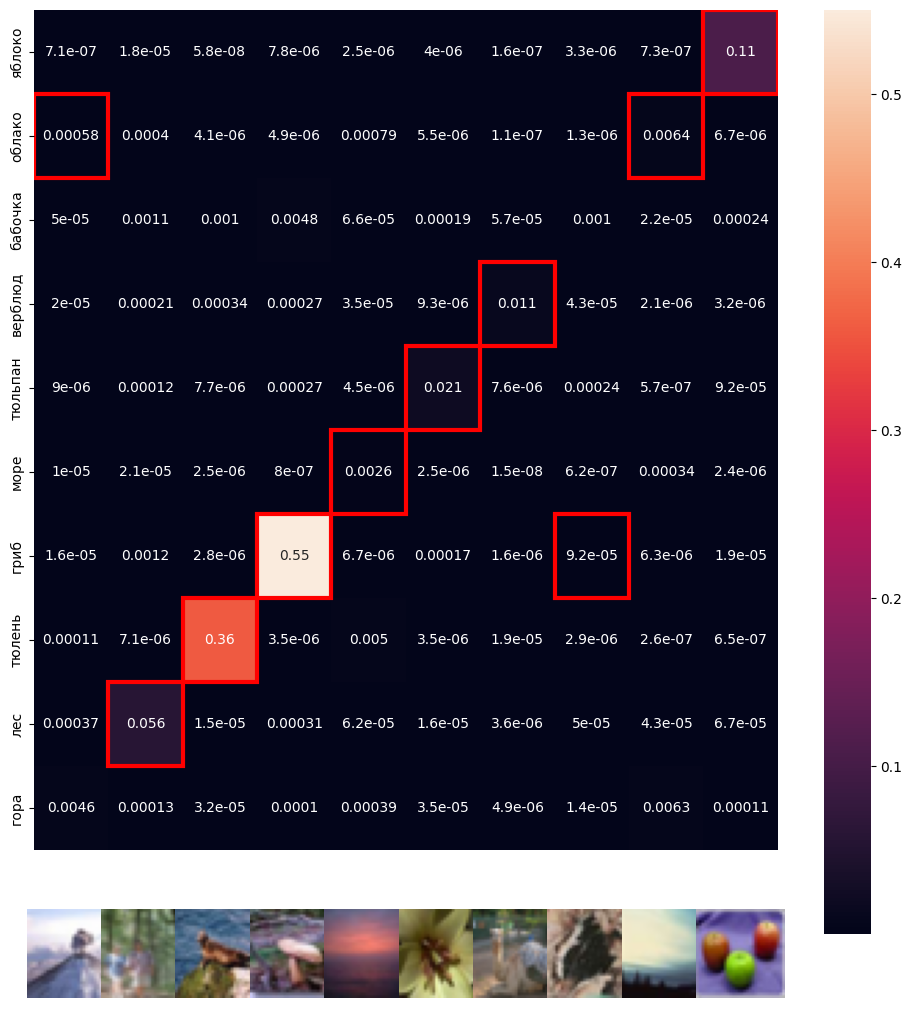

In [19]:
size = 12
plt.figure(figsize=(size, size))
ax = sns.heatmap(probs_for_heatmap, yticklabels=[labels_ru[l[0]] for l in names], annot=True)
for i in range(len(mask)):
    column_max = probs_for_heatmap[i].index(max(probs_for_heatmap[i]))
    ax.add_patch(Rectangle((i, column_max),1,1, fill=False, edgecolor='red', lw=3))
for i in range(len(mask)):
    imagebox = OffsetImage(X_test[i], zoom=2)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (i + 0.5, -0.5), frameon=False, box_alignment=(0.5, 1.2))
    ax.add_artist(ab)
ax.set_ylim(-1, 10)

Изображения, классифицированные неправильно

In [20]:
def accuracy_plots(names, probs, X, y, k=1):
  for i in range(len(names)):
      _, top = probs[i].topk(k, dim=-1)
      if names[i] not in top.numpy():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.imshow(X[i])
        ax1.set_xlabel(f"predict {labels_ru[int(top.numpy()[0][0])]}, true {labels_ru[y[i][0]]}")
        bar = ax2.bar(range(len(probs[i][0].tolist())), probs[i][0].tolist())
        bar[int(y[i][0])].set_color('g')
        plt.show()
  pass

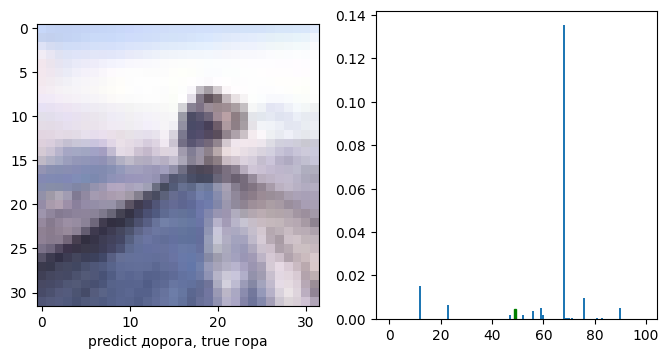

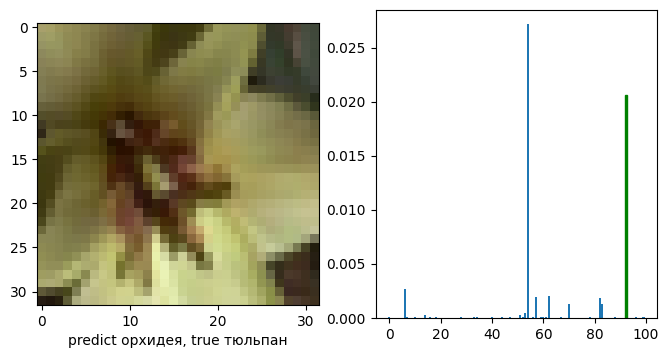

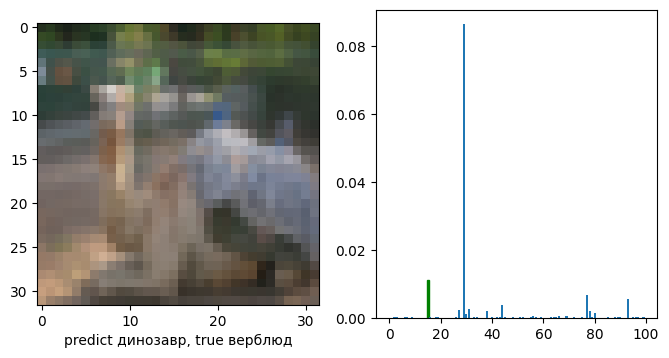

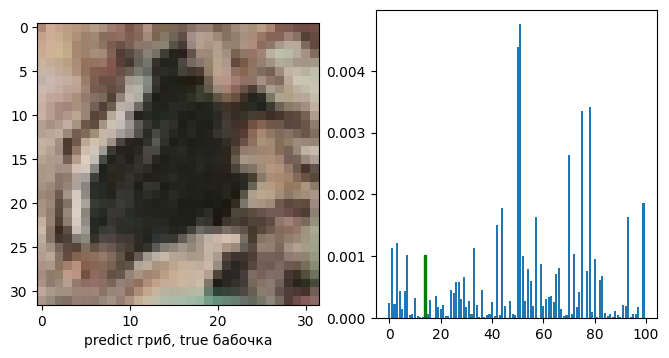

In [21]:
accuracy_plots(names, probs, X_test, y_test)